In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')
from skimage.draw import line_aa

In [2]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5],
        std =[0.5]
        # mean=[0.5,0.5,0.5],
        # std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [103]:
nImages = 10000
imgSize = 30

x   = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)


# initialize tensors containing images and labels
images = torch.zeros(nImages,1,imgSize,imgSize)
labels = torch.zeros(nImages,1)
horiz = 0

for i in range(nImages):

    # create the gaussian random offset
    # ro = 2*np.random.randn(2)
    
    # create the gaussian random width
    # width = np.random.rand()/.6 + 1.8 
    
    # Create the gaussian equation with RO & Width 
    # G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*width**2) )

    # add noise ... 
    amountOfNoise = 1/5
    G  = np.random.randn(imgSize,imgSize)*amountOfNoise

    # add a random bar randomly
    barWidth = np.random.choice(np.arange(1,5))
    barStartPoint = np.random.choice(np.arange(1,imgSize-barWidth))
    if np.random.randn()>0:
        G[barStartPoint:barStartPoint+barWidth,] = 1
        horiz = 1
    else:
        G[:,barStartPoint:barStartPoint+barWidth] = 1
        horiz = 0

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i,:] = torch.Tensor( [horiz] )



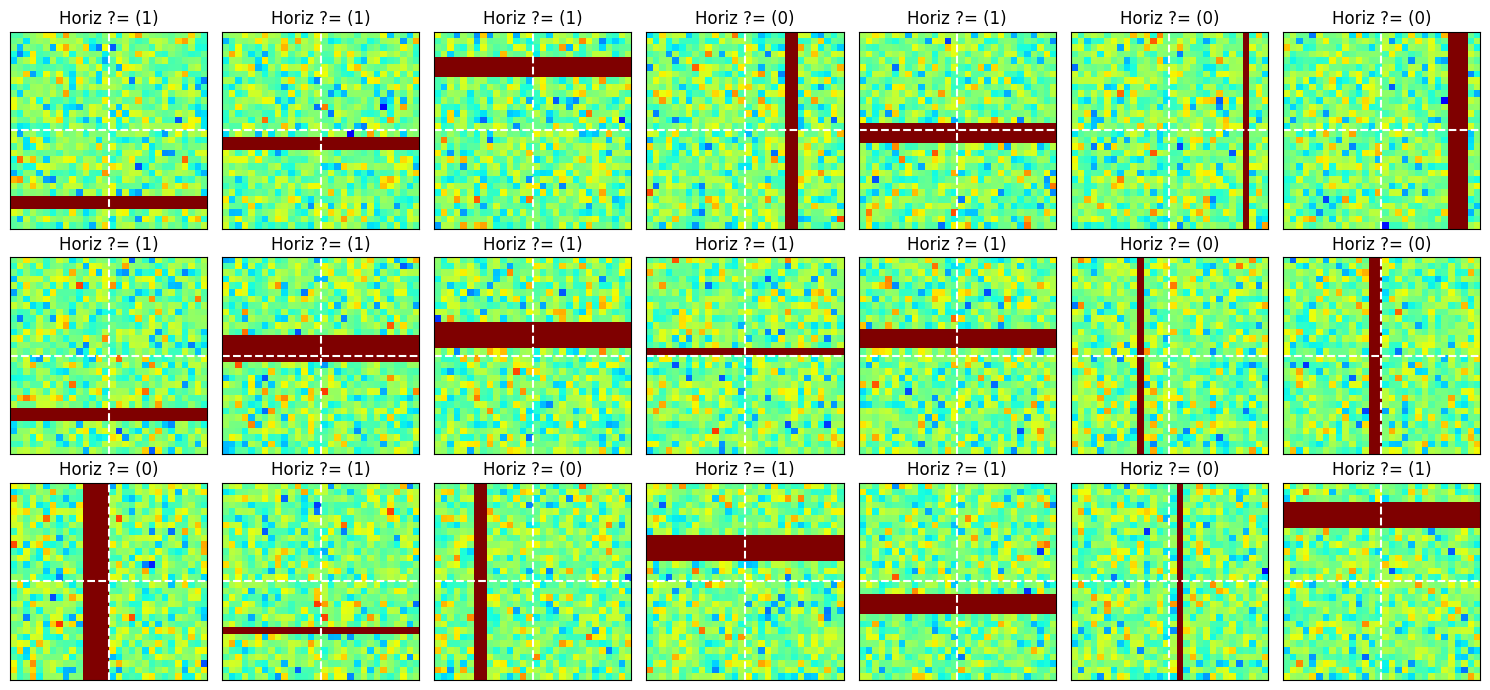

In [106]:

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,7))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nImages)
    G = np.squeeze( images[whichpic,:,:] )
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet',extent=[-4,4,-4,4],origin='upper')
    # ax.imshow(G,vmin=-1,vmax=1,cmap='jet')#,extent=[-4,4,-4,4],origin='upper')
    ax.set_title(f'Horiz ?= ({labels[whichpic,0]:.0f})')
                 #,{labels[whichpic,1]:.0f}), W={labels[whichpic,2]:.0f}')
    ax.plot([-4,4],[0,0],'w--')
    ax.plot([0,0],[-4,4],'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [109]:
# Step2: use scikit learn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

In [110]:
# Step 3: Convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data , test_labels)

In [111]:
# Step 4: Translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data,  batch_size=test_data.tensors[0].shape[0])

In [154]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            imgSize = len(train_data.tensors[0][0].squeeze()) #30
            print('imgsize= ',imgSize)
            inChans  = 1 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 0 # square if single input
            stride   = 1 # use maxpool instead of stride ... so stride = 1
            
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv2d(inChans,outChans,krnSize, stride, padding)
            self.bnorm1 = nn.BatchNorm2d(outChans) # 64
            outputSize = np.floor( (imgSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (30 + 2*0 - 3) / 1 ) + 1 = 28
            # output size = 28/2 = 14 b/c of pool
            
            # Second Convolution Layer
            self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, stride, padding)
            self.bnorm2 = nn.BatchNorm2d(outChans*2) # 128
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (14 + 2*0 - 3) / 1 ) + 1 = 12
            # output size = 12/2 = 6 b/c of pool
            
            # Third Convolution Layer
            self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, stride, padding)
            self.bnorm3 = nn.BatchNorm2d(outChans*2*2) # 256
            outputSize = np.floor( (outputSize+2*padding-krnSize)/stride ) + 1
            outputSize = np.floor(outputSize/2) # pool
            # output size = floor( (6 + 2*0 - 3) / 1 ) + 1 = 4
            # output size = 4/2 = 2 b/c of pool

            ### ------- Linear Layer ------- ###
            # self.fc1 = nn.Linear(flattened_size,200) #1024, 256
            flattened_size = (outputSize**2) * (outChans*2)
            # print(flattened_size)
            self.fc1 = nn.Linear(int(flattened_size),200) #1024, 256
            self.fc2 = nn.Linear(200,50)
            self.fc3 = nn.Linear(50,10)
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = F.max_pool2d( self.conv1(x), 2)
            x = F.leaky_relu( self.bnorm1(x)  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = F.max_pool2d( self.conv2(x), 2)
            x = F.leaky_relu( self.bnorm2(x)  )
            if self.print: print(f'Second conv: {list(x.shape)}')

            x = F.max_pool2d( self.conv3(x), 2)
            x = F.leaky_relu( self.bnorm3(x)  )
            if self.print: print(f'Third conv: {list(x.shape)}')

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.leaky_relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
            
            x = F.leaky_relu( self.fc2(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc2: {list(x.shape)}')
            
            x = self.fc3(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.001,
                                weight_decay=1e-4)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [155]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

X, y = next(iter(train_loader))

X = X.to(device)
y = y.to(device)

yHat = net2(X)

#check size of output
print(yHat.shape)

#compute the loss
loss = lossfun2(yHat, torch.squeeze(y))
print(loss)

imgsize=  30
Input: [16, 1, 30, 30]
First conv: [16, 64, 14, 14]
Second conv: [16, 128, 6, 6]
Third conv: [16, 256, 2, 2]
Vectorized: [16, 1024]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x1024 and 512x200)

In [108]:
# imgSize = 31
# nImages = 10000

# x   = np.linspace(-4,4,imgSize)
# X,Y = np.meshgrid(x,x)

# img = np.zeros((imgSize, imgSize), dtype=np.uint8)
# y = ax

# # rr, cc, val = line_aa(0, 0, 0, 30) # Horizontal #start here, -> x2 increase -> +ve slope
# # rr, cc, val = line_aa(0, 0, 30, 30) # +ve slope -> y2 
# # rr, cc, val = line_aa(0, 0, 30, 0) # vertical 
# # rr, cc, val = line_aa(0, 30, 30, 0) # -ve slope

# # rr, cc, val = line_aa(30, 30, 0, 0)
# img[rr, cc] = val * 255
# fig,ax = plt.subplots(1,2,figsize=(10,5))
# # ax[0].set_xlim([-30,30])
# ax[0].imshow(img, origin="lower")
